In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z = np.linspace(82,120,38)#11 8
r = np.logspace(0,1,10000)
E0 = 8.854187817*10e-12

In [3]:
def potencial(z,r):
    v = 2*(z-2)*np.exp(2)/(4*np.pi*E0*r)
    return v

In [4]:
X, Y = np.meshgrid(z, r)
V = potencial(X,Y)
V

array([[1.06255239e+12, 1.07619326e+12, 1.08983414e+12, ...,
        1.53998302e+12, 1.55362390e+12, 1.56726477e+12],
       [1.06230773e+12, 1.07594547e+12, 1.08958320e+12, ...,
        1.53962844e+12, 1.55326617e+12, 1.56690390e+12],
       [1.06206313e+12, 1.07569772e+12, 1.08933232e+12, ...,
        1.53927393e+12, 1.55290852e+12, 1.56654312e+12],
       ...,
       [1.06304187e+11, 1.07668903e+11, 1.09033619e+11, ...,
        1.54069245e+11, 1.55433961e+11, 1.56798677e+11],
       [1.06279710e+11, 1.07644112e+11, 1.09008514e+11, ...,
        1.54033769e+11, 1.55398171e+11, 1.56762573e+11],
       [1.06255239e+11, 1.07619326e+11, 1.08983414e+11, ...,
        1.53998302e+11, 1.55362390e+11, 1.56726477e+11]])

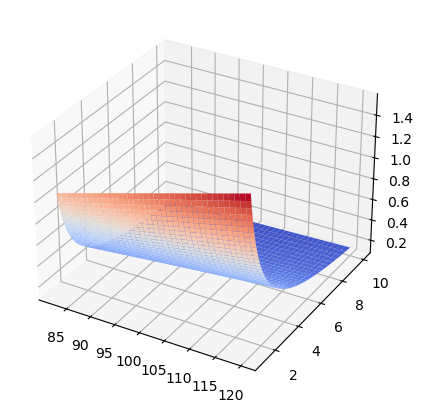

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,V,cmap='coolwarm')


In [6]:
def neutrones(z):
    n = -4*10*(-5)*z**3 + 0.0108*z**2 + 0.9251*z + 0.1832
    return int(n)

def binEnergy(z):
  N = neutrones(z)
  A = z + N
  s = 0
  if (N%2) == 1 and (z%2) == 1:
    s = -33
  elif (N%2) == 0 and (z%2) == 0:
    s = 33

  term1 = 14
  term2 = - 13/(A**(1/3))
  term3 = - (0.585*z**2)/(A**(4/3))
  term4 = - (19.3*(N-z)**2)/(A**2)
  term5 = s/(A**(7/4))
  
  E = A*(term1 + term2 + term3 + term4 + term5)*-10e-9

  return E

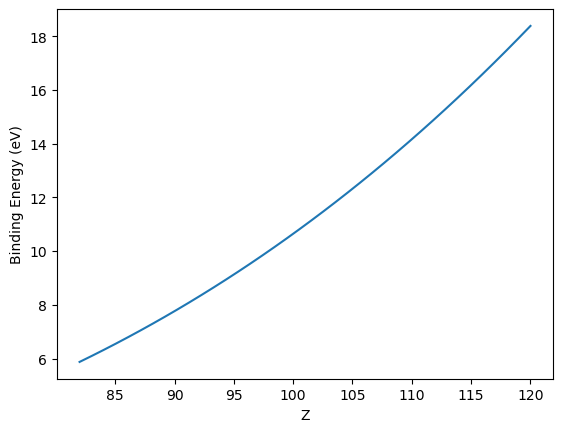

In [26]:
BEarr = []
for i in range(len(z)):
    BEarr.append(binEnergy(z[i]))
plt.xlabel('Z')
plt.ylabel('Binding Energy (eV)')
plt.plot(z,BEarr)
plt.show()


Potential barrier = 264.0 eV
Potential barrier width = 0.25 A
(The boundary of the simulation domain is assumed to be an infinite barrier)
Energy = 101.2 eV
Spread = 0.8 A

Grid size = 1.00e-02 A
Time step = 7.76e-06 fs


C:\Users\Camelo\AppData\Local\Temp\ipykernel_20848\4291291209.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig0.show()
C:\Users\Camelo\AppData\Local\Temp\ipykernel_20848\4291291209.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\Camelo\AppData\Local\Temp\ipykernel_20848\4291291209.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


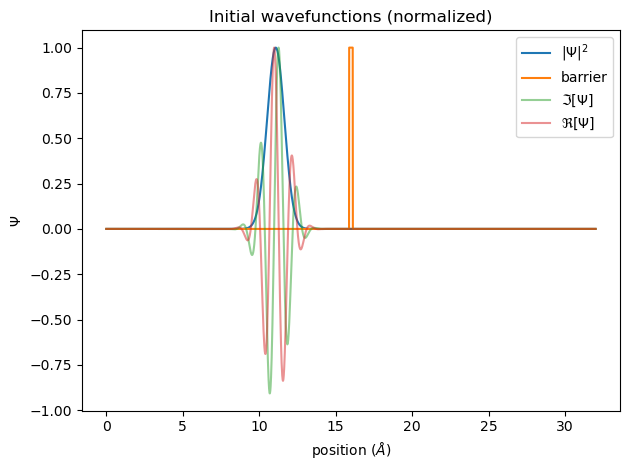

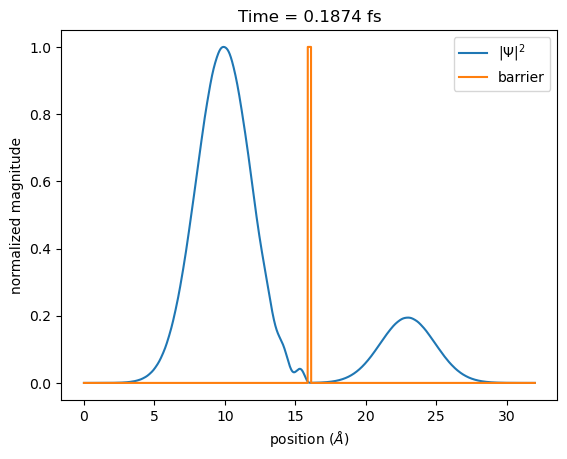

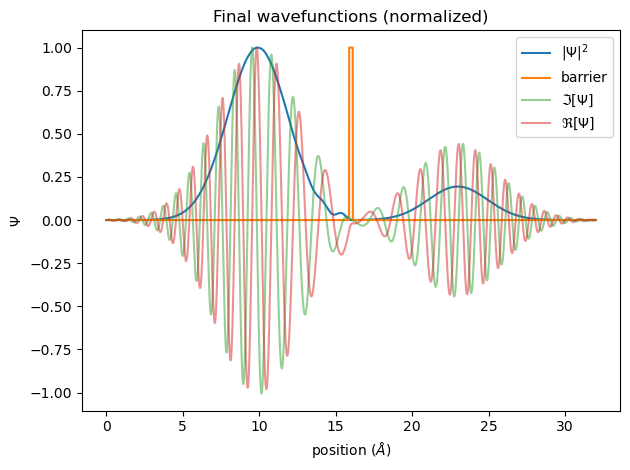

In [7]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt


class QMfdtd:
    def __init__(self, V0, bw, ke, sig):
        self.V0 = V0 * sc.value('electron volt')  # height of potential barrier in Joules
        self.ke = ke * sc.value('electron volt')  # kinetic energy of electron in Joules
        self.k0 = np.sqrt(self.ke * 2 * sc.m_e / (sc.hbar ** 2))  # wave vector of electron in m^-1
        self.bw = bw * sc.value('Angstrom star')  # potential barrier width in m
        self.sig = sig * sc.value('Angstrom star')  # Initial spread of Gaussian wavefunction
        self.dx = np.minimum((self.bw / 25.0), (self.sig / 25.0))  # grid cell size
        self.dt = 0.9 * sc.hbar / ((sc.hbar ** 2 / (sc.m_e * self.dx ** 2)) + (self.V0 / 2.0))  # time step size
        length = 40 * np.maximum(self.bw, self.sig)  # length of the simulation domain
        self.ll = int(length / self.dx)  # total number of grid points in the domain
        vel = sc.hbar * self.k0 / sc.m_e
        self.tt = int(0.35 * length / vel / self.dt)  # total number of time steps in the simulation
        self.lx = np.linspace(0.0, length, self.ll)  # 1D position vector along x
        # potential barrier
        self.Vx = np.zeros(self.ll)
        bwgrid = int(self.bw / (2.0 * self.dx))
        bposgrid = int(self.ll / 2.0)
        bl = bposgrid - bwgrid
        br = bposgrid + bwgrid
        self.Vx[bl:br] = self.V0
        # wavefunction arrays
        self.psir = np.zeros((self.ll))
        self.psii = np.zeros((self.ll))
        self.psimag = np.zeros(self.ll)
        ac = 1.0 / np.sqrt((np.sqrt(np.pi)) * self.sig)
        x0 = bl * self.dx - 6 * self.sig
        psigauss = ac * np.exp(-(self.lx - x0) ** 2 / (2.0 * self.sig ** 2))
        self.psir = psigauss * np.cos(self.k0 * self.lx)
        self.psii = psigauss * np.sin(self.k0 * self.lx)
        self.psimag = self.psir ** 2 + self.psii ** 2
        # fdtd update coefficients
        self.c1 = sc.hbar * self.dt / (2.0 * sc.m_e * self.dx ** 2)
        self.c2 = self.dt / sc.hbar

    # The main FDTD update function.
    def fdtd_update(self):
        self.psii[1:self.ll - 1] = (self.c1 * (self.psir[2:self.ll] - 2.0 * self.psir[1:self.ll - 1]
                                               + self.psir[0:self.ll - 2])
                                    - self.c2 * self.Vx[1:self.ll - 1] * self.psir[1:self.ll - 1]
                                    + self.psii[1:self.ll - 1])
        self.psir[1:self.ll - 1] = (-self.c1 * (self.psii[2:self.ll] - 2.0 * self.psii[1:self.ll - 1]
                                                + self.psii[0:self.ll - 2])
                                    + self.c2 * self.Vx[1:self.ll - 1] * self.psii[1:self.ll - 1]
                                    + self.psir[1:self.ll - 1])
        self.psimag = self.psir ** 2 + self.psii ** 2


def run_sim(V0_in, bw_in, ke_in, sig_in):
    q1 = QMfdtd(V0_in, bw_in, ke_in, sig_in)
    print('')
    print('Potential barrier =', round(q1.V0 / sc.value('electron volt'), 2), 'eV')
    print('Potential barrier width =', round(q1.bw / sc.value('Angstrom star'), 2), 'A')
    print('(The boundary of the simulation domain is assumed to be an infinite barrier)')
    print('Energy =', round(q1.ke / sc.value('electron volt'), 2), 'eV')
    print('Spread =', round(q1.sig / sc.value('Angstrom star'), 2), 'A')
    print('')
    print('Grid size =', '%.2e' % (q1.dx / sc.value('Angstrom star')), 'A')
    print('Time step =', "%.2e" % (q1.dt * 1e15), 'fs')
    plt.ion()
    fig0 = plt.figure()
    ax0 = fig0.add_subplot(111)
    ax0.set_xlabel('position ($\AA$)')
    ax0.set_ylabel('$\Psi$')
    ax0.set_title('Initial wavefunctions (normalized)')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psii / np.amax(q1.psii), label='$\Im[\Psi]$', alpha=0.5)
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psir / np.amax(q1.psir), label='$\Re[\Psi]$', alpha=0.5)
    ax0.legend()
    fig0.show()
    fig0.tight_layout()
    fig0.canvas.draw()
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('position ($\AA$)')
    ax1.set_ylabel('norm magnitude')
    fig1.show()
    fig1.canvas.draw()
    for nn in range(0, q1.tt):
        q1.fdtd_update()
        if nn % 50 == 0:
            tstr = 'Time = ' + str(round(nn * q1.dt * 1e15, 4)) + ' fs'
            ax1.clear()
            ax1.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
            ax1.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
            ax1.legend()
            ax1.set_title(tstr)
            ax1.set_xlabel('position ($\AA$)')
            ax1.set_ylabel('normalized magnitude')
            fig1.canvas.draw()
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel('position ($\AA$)')
    ax2.set_ylabel('$\Psi$')
    ax2.set_title('Final wavefunctions (normalized)')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psii / np.amax(q1.psii), label='$\Im[\Psi]$', alpha=0.5)
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psir / np.amax(q1.psir), label='$\Re[\Psi]$', alpha=0.5)
    ax2.legend()
    fig2.show()
    fig2.tight_layout()
    fig2.canvas.draw()

    
run_sim(264, 0.25, binEnergy(212), 0.8)